In [1]:
import os

from tqdm.notebook import tqdm

from ultralytics import YOLO

import matplotlib.pyplot as plt
import matplotlib.patches as patches

%matplotlib inline

In [2]:
model = YOLO("models/26_6_2024_shampoo_5_class.pt")

In [4]:
def _is_image(f: str) -> bool:
    return any(f.lower().endswith(ext) for ext in {".png", ".jpg", ".jpeg"})

def get_sources(root: str, n: int | None = None) -> list[str]:
    files = os.listdir(root)
    files = map(lambda f: os.path.join(root, f), files)
    files = list(filter(_is_image, files))
    
    if n is not None:
        files = files[:min(len(files), n)]    
    return files

sources0 = get_sources("data/eyeshift/0/", n=300)  # TODO wrap inside DataFrame/PyTorch Dataset
sources1 = get_sources("data/eyeshift/1/", n=300)

In [6]:
results0 = [model(src, classes=[1, 2, 4], verbose=False)[0] for src in tqdm(sources0)]
results1 = [model(src, classes=[1, 2, 4], verbose=False)[0] for src in tqdm(sources1)]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

In [9]:
class_names = {"cut" : 0,
               "eye_patch" : 1,
               "horizontal" : 2,
               "shampoo" : 3,
               "vertical" : 4}

labels = {0: True,
          1: False}

In [10]:
def _check_in_between(val: float, mean: float, spread: float, alpha: float = 1) -> bool:
    return mean - spread * alpha <= val <= mean + spread * alpha

def is_batch_defective(r):
    verticals = r.boxes[r.boxes.cls == class_names["vertical"]]
    horizontals = r.boxes[r.boxes.cls == class_names["horizontal"]]
    eye_patches = r.boxes[r.boxes.cls == class_names["eye_patch"]]

    if len(eye_patches) == 0:
        return None
    
    rows = [horizontals[horizontals.xywh[:, 1] < 300],
            horizontals[horizontals.xywh[:, 1] >= 300]]  # TODO unsupervised clustering model?
    row_heights = [row.xywh[:, -1].mean() / 2 for row in rows]
    row_positions = [row.xywh[:, 1].mean() for row in rows]
    
    avg_w = verticals.xywh[:, 2].mean() * 1.75 / 2
    
    for (x, y, _, _) in eye_patches.xywh:
        # noinspection PyTypeChecker
        x_check = any((x <= verticals.xywh[:, 0] + avg_w) & (x >= verticals.xywh[:, 0] - avg_w))
        y_check = any(_check_in_between(y, row_positions[r], row_heights[r]) for r in range(len(rows)))
        
        if not (y_check and x_check):
            return True
        
    return False

In [16]:
def test_classifier(results, label: bool, verbose: bool = True):
    wrong = []
    total = 0

    for i, r in enumerate(results):
        if (pred := is_batch_defective(r)) is None:
            continue
            
        total += 1
        if pred != label:
            wrong.append(i)
    
    if verbose:
        print(f"Incorrect: {len(wrong)}/{total} or {100 * len(wrong) / total:.2f}%")
    return wrong, total

In [26]:
wrong0, total0 = test_classifier(results0, labels[0])
wrong1, total1 = test_classifier(results1, labels[1])
print(f"Accuracy: {100 - 100 * (len(wrong0) + len(wrong1)) / (total0 + total1):.2f}%")

Incorrect: 42/276 or 15.22%
Incorrect: 40/281 or 14.23%
Accuracy: 85.28%


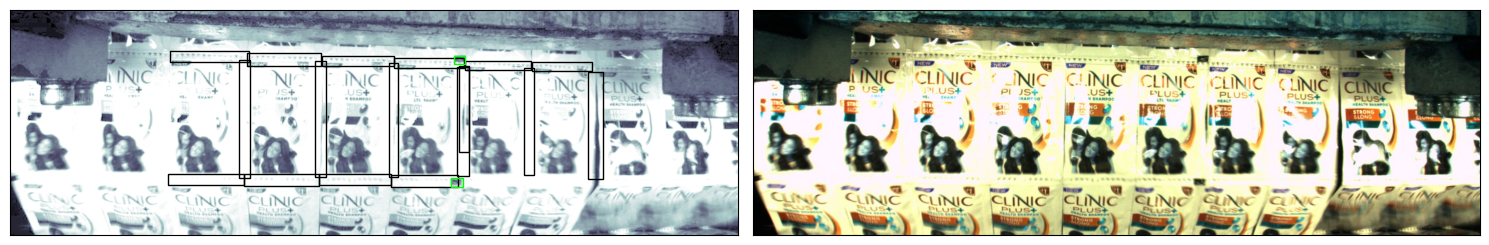

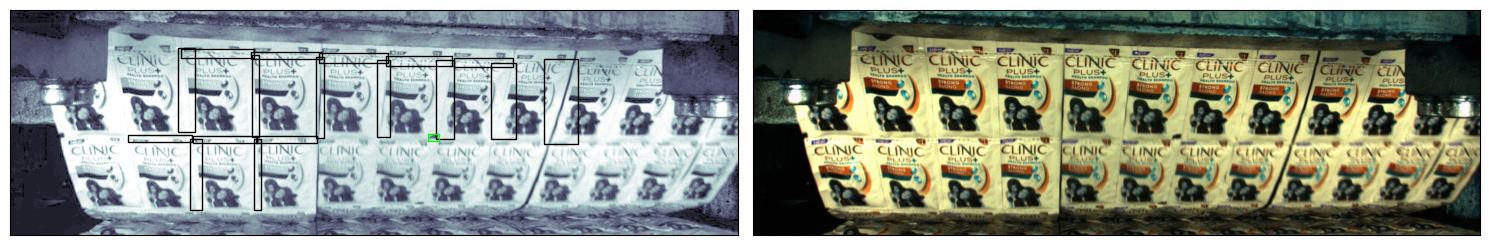

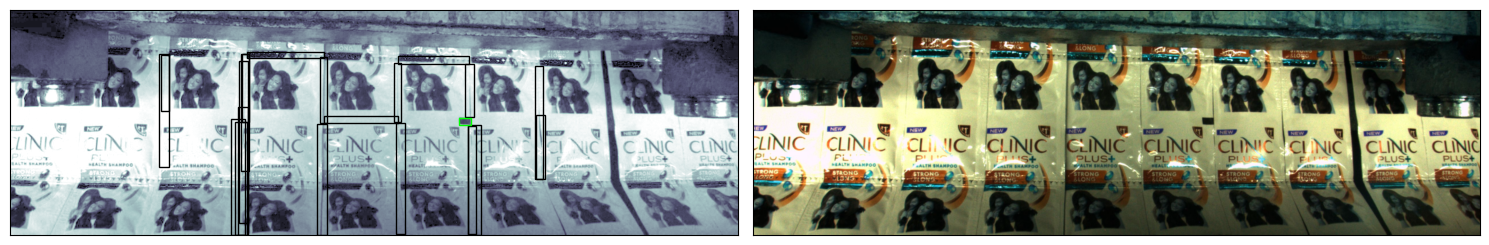

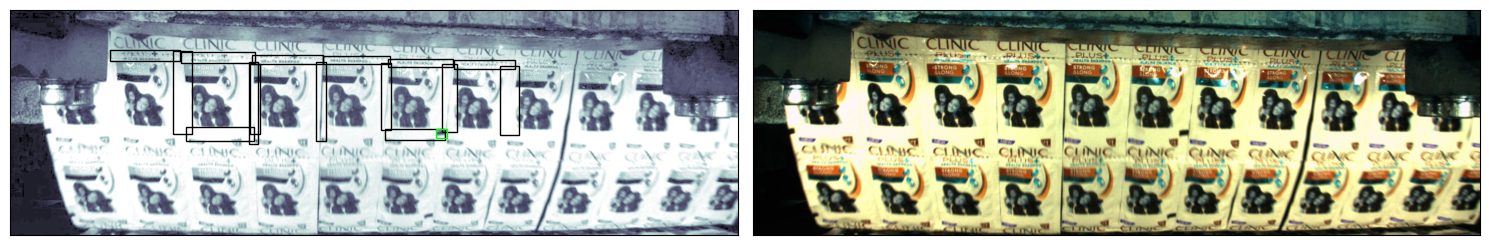

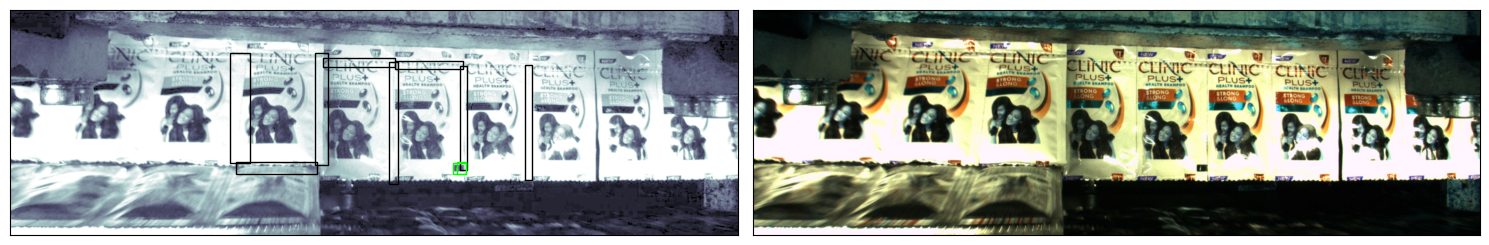

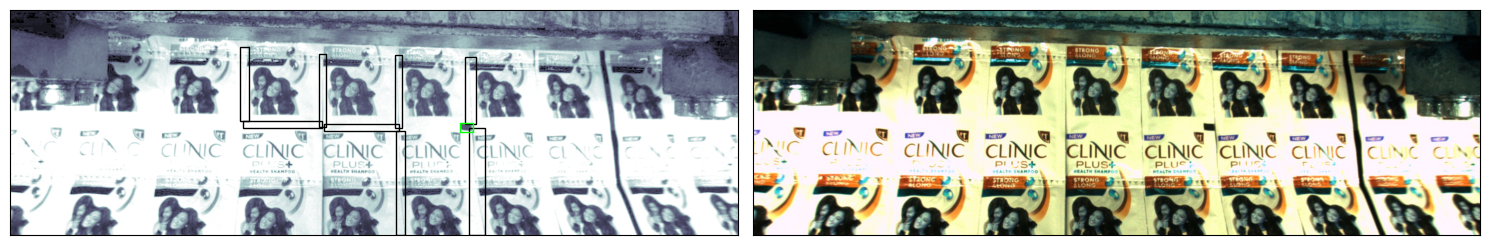

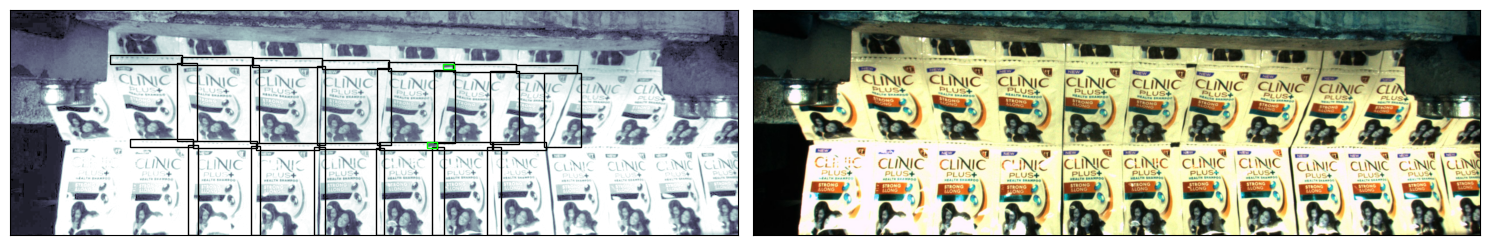

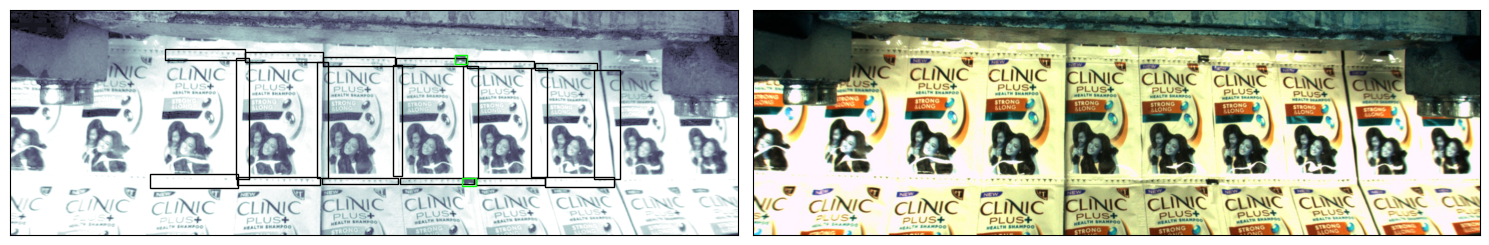

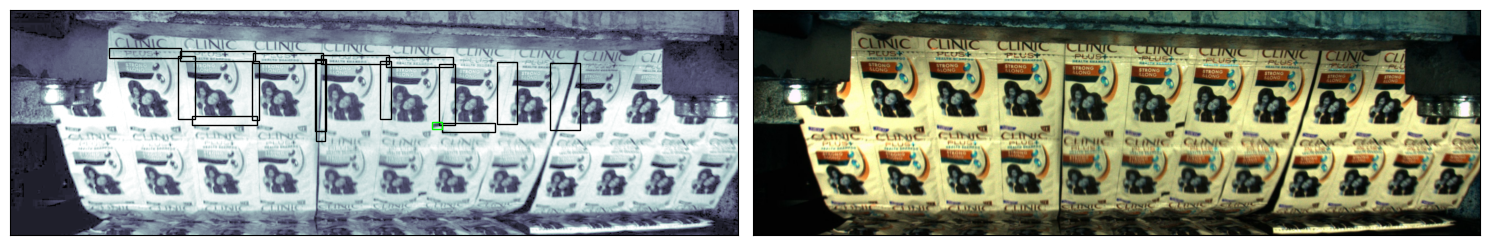

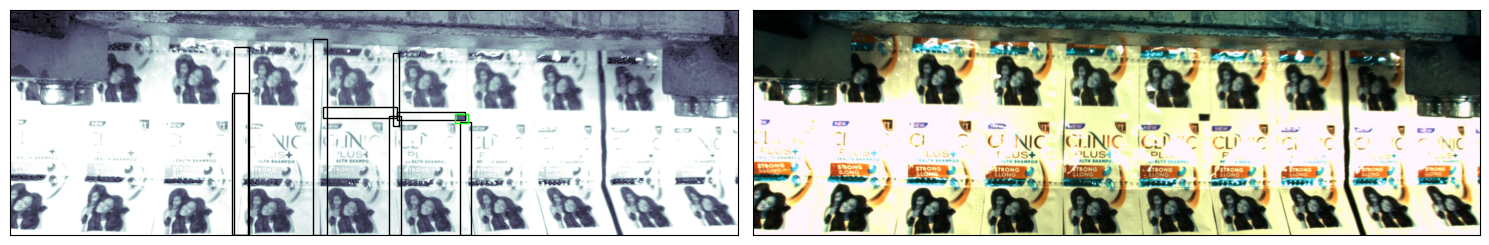

In [29]:
def plot_img(img, ax, cmap="bone", **kwargs):
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
    ax.imshow(img, cmap=cmap, **kwargs)
    

def plot_rectangle(p, ax, **kwargs):
    x1, y1, x2, y2 = p
    ax.add_patch(patches.Rectangle((x1, y1), x2 - x1, y2 - y1, facecolor="none", **kwargs))
    

def plot_errors(wrongs, results, n=10):
    for k in wrongs[:min(n, len(wrongs))]:
        r = results[k]
        
        _, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15, 12))
        plot_img(r.orig_img[:, :, 0] ** 0.4, ax1)
        plot_img(r.orig_img, ax2)
    
        classes = r.boxes.cls
        verticals = r.boxes[classes == class_names["vertical"]]
        horizontals = r.boxes[classes == class_names["horizontal"]]
        eye_patches = r.boxes[classes == class_names["eye_patch"]]
    
        for pos in horizontals.xyxy:
            plot_rectangle(pos, ax1, edgecolor="black")
            
        for pos in verticals.xyxy:
            plot_rectangle(pos, ax1, edgecolor="black")
    
        for pos in eye_patches.xyxy:
            plot_rectangle(pos, ax1, edgecolor="red" if is_batch_defective(r) else "lime")
    
        plt.tight_layout()
        plt.show()
        

plot_errors(wrong0, results0)